# TGDS Model with Thevenin Input

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.thevenin_lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [2]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 2,                  # number of input features
    'd_t': 0.25,                      # current integration factor
    'num_repeat': 10,                 # repetition factor for each training profile to create more auxiliary data
    'theory_model': 8656,             # the unique thevenin model ID for which the parameters have been computed
    'feature_range_delta_low': -1,    # lower bound of voltage label after scaling\n",
    'feature_range_delta_high': 1,    # upper -||-\n",
    'boundary_delta_low': -0.1,       # lower bound of voltage value range in V
    'boundary_delta_high': 0.1,       # upper -||-   
}

HYPER_PARAMS.update({'n_lstm_units_1':200}) 

#     'theory_model': 5595, 

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [3]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
# training_sets = TRAINING_SETS['10A_all'] + TRAINING_SETS['-10A_all'] + TRAINING_SETS['25A_all'] + TRAINING_SETS['-25A_all']
training_sets = TRAINING_SETS['10A_all']

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
print('--- Train ---')  
X_train, y_train, scalers_train = util.prepare_thevenin_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
print('--- Validation ---')
X_validation, y_validation, _ = util.prepare_thevenin_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
print('--- Test ---')
X_test, y_test, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

--- Train ---
Input: (79000, 100, 2)  Output/Label: (79000, 1)
--- Validation ---
Input: (1500, 100, 2)  Output/Label: (1500, 1)
--- Test ---
Input: (1500, 100, 2)  Output/Label: (1500, 1)


### Prepare non-sequential input

In [4]:
cond_train = util.prepare_intermediate_volt(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_validation = util.prepare_intermediate_volt(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_test = util.prepare_intermediate_volt(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

### Initialize and Train Model

In [5]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Epoch 1/5
2469/2469 [==============================] - 156s 63ms/step - loss: 3.2112e-04 - mse: 3.2112e-04 - mae: 0.0132
Epoch 2/5
2469/2469 [==============================] - 156s 63ms/step - loss: 2.3561e-04 - mse: 2.3561e-04 - mae: 0.0118
Epoch 3/5
2469/2469 [==============================] - 154s 62ms/step - loss: 2.1791e-04 - mse: 2.1791e-04 - mae: 0.0110
Epoch 4/5
2469/2469 [==============================] - 154s 62ms/step - loss: 2.2475e-04 - mse: 2.2475e-04 - mae: 0.0112
Epoch 5/5
2469/2469 [==============================] - 153s 62ms/step - loss: 2.1734e-04 - mse: 2.1734e-04 - mae: 0.0111
Training time: 774.431s


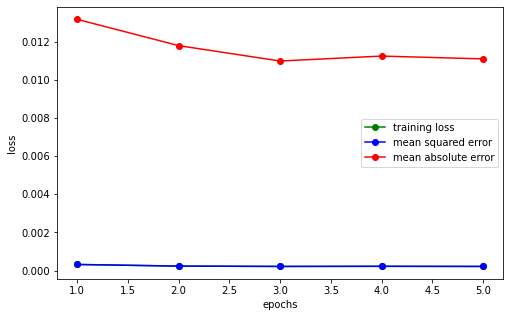

In [6]:
_, fig = lstm.train([X_train, cond_train], y_train, scalers_train)

# save model, hyperparameters and plots
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_variables-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A']
2469/2469 [==============================] - 49s 20ms/step
Prediction time on Training Set:  48.831s
47/47 [==============================] - 1s 21ms/step
Prediction time on Validation Set:  0.995s
47/47 [==============================] - 1s 20ms/step
Prediction time on Test Set:  0.964s
###########################################################
            Training    Validation    Test
--------  ----------  ------------  ------
MSE (μV)     24             7.2     7.2
MAE (V)       0.0038        0.0019  0.0019
MaxE (V)      0.013         0.0119  0.0119
###########################################################


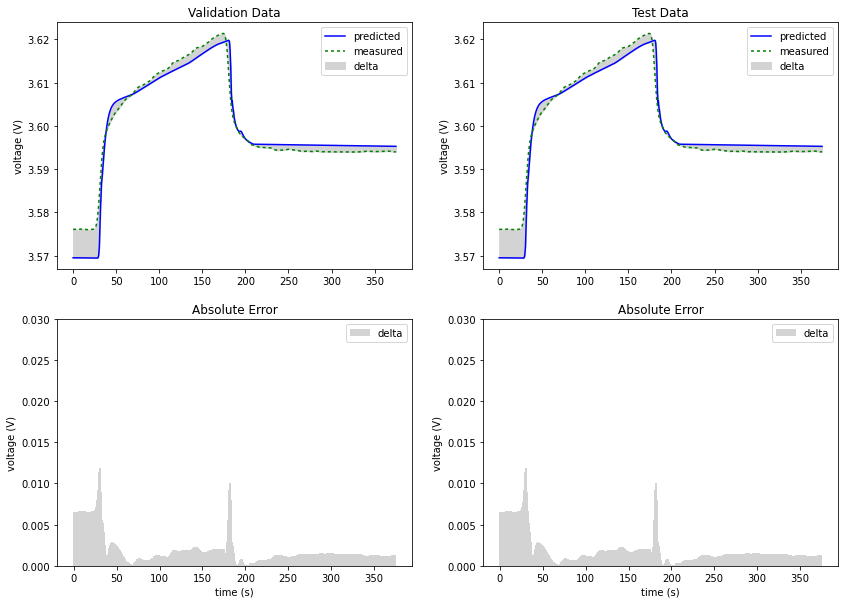

In [7]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, _, _, fig = lstm.test([X_train, cond_train], y_train, [X_validation, cond_validation], y_validation, [X_test, cond_test], y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/theory_guided_variables-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [8]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_thevenin_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

cond_case_1 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_case_2 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
cond_case_3 = util.prepare_intermediate_volt(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (3100, 100, 2)  Output/Label: (3100, 1)
Input: (1600, 100, 2)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
2469/2469 [==============================] - 50s 20ms/step
Prediction time on Training Set:  50.492s
47/47 [==============================] - 1s 22ms/step
Prediction time on Use Case 1:  1.042s
97/97 [==============================] - 2s 21ms/step
Prediction time on Use Case 2:  2.03s
50/50 [==============================] - 1s 20ms/step
Prediction time on Use Case 3:  1.145s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)     24             7.2          94.5          44.6
MAE (V)       0.0038        0.0019        0.0066        0.0055
MaxE (V)      0.013         0.0119        0.0259        0.0116
##############################################################


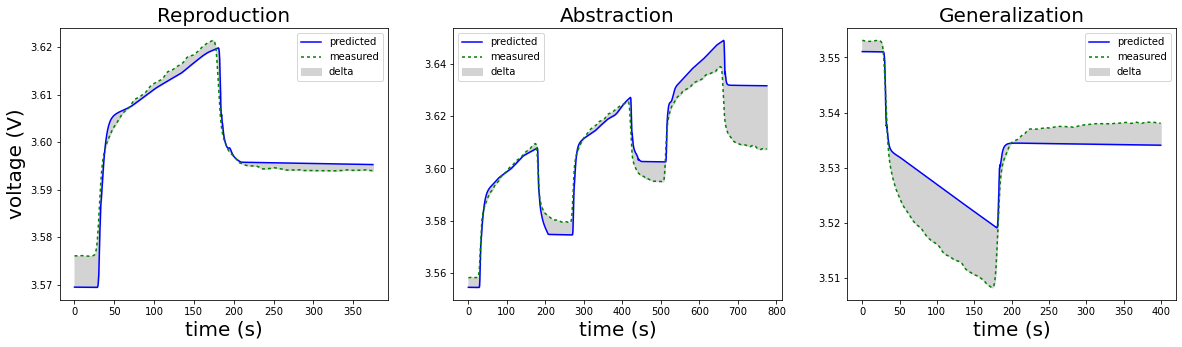

In [9]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

lstm.test_usecases([X_train, cond_train], y_train, [X_case_1, cond_case_1], y_case_1, [X_case_2, cond_case_2], y_case_2, [X_case_3, cond_case_3], y_case_3, scalers_train)